# Multi-Output Regression for Typhoon Impact Prediction

This notebook implements a Multi-Output Regression model to predict typhoon impact metrics based on meteorological features.

## Input Features:
- `max_sustained_wind_kph`: Maximum sustained wind speed in kph
- `typhoon_type`: Type/Category of typhoon
- `max_24hr_rainfall_mm`: Maximum 24-hour rainfall in mm
- `total_storm_rainfall_mm`: Total storm rainfall in mm
- `min_pressure_hpa`: Minimum pressure in hPa

## Output Targets:
- `families`: Number of affected families
- `person`: Number of affected persons
- `brgy`: Number of affected barangays
- `dead`: Number of deaths
- `injured/ill`: Number of injured/ill
- `missing`: Number of missing persons
- `cost`: Damage cost
- `partially`: Partially damaged structures
- `totally`: Totally damaged structures

In [1]:
# Core data manipulation and numerical libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn components
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# XGBoost for regression
import xgboost as xgb

# Hyperparameter optimization
import optuna
from optuna.samplers import TPESampler

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Model persistence
import joblib
from datetime import datetime

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. Data Loading and Exploration

In [2]:
# Load the dataset
df = pd.read_csv('../data/typhoon_impact_with_extreme_weather.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1776, 30)


,Typhoon Name,Year,Region,Province,City/Municipality,Families,Person,Brgy,Dead,Injured/Ill,...,PAR_END,Duration_in_PAR_Hours,Max_Sustained_Wind_kph,Typhoon_Type,Max_24hr_Rainfall_mm,Total_Storm_Rainfall_mm,Min_Pressure_hPa,Weather_Station_Mapped,Weather_Records_Found,Weather_Days_Covered
0,BETTY,2023,2,BATANES,BASCO,3608,11120,6,0,0,...,6/1/2023,133.0,195,STY,25.6,39.00,977.1,1,6,6
1,BETTY,2023,2,BATANES,ITBAYAT,968,3028,5,0,0,...,6/1/2023,133.0,195,STY,20.3,32.71,1000.5,1,6,6
2,BETTY,2023,2,BATANES,IVANA,444,1532,4,0,0,...,6/1/2023,133.0,195,STY,25.6,39.00,977.1,1,6,6
3,BETTY,2023,2,BATANES,MAHATAO,575,1792,4,0,0,...,6/1/2023,133.0,195,STY,25.6,39.00,977.1,1,6,6
4,BETTY,2023,2,BATANES,SABTANG,575,1955,6,0,0,...,6/1/2023,133.0,195,STY,25.6,39.00,977.1,1,6,6


In [3]:
# Display dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1776 entries, 0 to 1775
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Typhoon Name             1776 non-null   object 
 1   Year                     1776 non-null   int64  
 2   Region                   1776 non-null   int64  
 3   Province                 1776 non-null   object 
 4   City/Municipality        1776 non-null   object 
 5   Families                 1776 non-null   int64  
 6   Person                   1776 non-null   int64  
 7   Brgy                     1776 non-null   int64  
 8   Dead                     1776 non-null   int64  
 9   Injured/Ill              1776 non-null   int64  
 10  Missing                  1776 non-null   int64  
 11  Totally                  1776 non-null   int64  
 12  Partially                1776 non-null   int64  
 13  Total                    1776 non-null   int64  
 14  Quantity                

In [4]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Typhoon Name               0
Year                       0
Region                     0
Province                   0
City/Municipality          0
Families                   0
Person                     0
Brgy                       0
Dead                       0
Injured/Ill                0
Missing                    0
Totally                    0
Partially                  0
Total                      0
Quantity                   0
Cost                       0
Nearest_Station            0
Station_Province           0
Distance_km                0
PAR_START                  0
PAR_END                    0
Duration_in_PAR_Hours      0
Max_Sustained_Wind_kph     0
Typhoon_Type               0
Max_24hr_Rainfall_mm       0
Total_Storm_Rainfall_mm    0
Min_Pressure_hPa           0
Weather_Station_Mapped     0
Weather_Records_Found      0
Weather_Days_Covered       0
dtype: int64


In [5]:
# Display all columns
print("All columns in dataset:")
print(df.columns.tolist())

All columns in dataset:
['Typhoon Name', 'Year', 'Region', 'Province', 'City/Municipality', 'Families', 'Person', 'Brgy', 'Dead', 'Injured/Ill', 'Missing', 'Totally', 'Partially', 'Total', 'Quantity', 'Cost', 'Nearest_Station', 'Station_Province', 'Distance_km', 'PAR_START', 'PAR_END', 'Duration_in_PAR_Hours', 'Max_Sustained_Wind_kph', 'Typhoon_Type', 'Max_24hr_Rainfall_mm', 'Total_Storm_Rainfall_mm', 'Min_Pressure_hPa', 'Weather_Station_Mapped', 'Weather_Records_Found', 'Weather_Days_Covered']


In [6]:
# Convert column names to lowercase for consistency
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('/', '_')
print("Columns after normalization:")
print(df.columns.tolist())

Columns after normalization:
['typhoon_name', 'year', 'region', 'province', 'city_municipality', 'families', 'person', 'brgy', 'dead', 'injured_ill', 'missing', 'totally', 'partially', 'total', 'quantity', 'cost', 'nearest_station', 'station_province', 'distance_km', 'par_start', 'par_end', 'duration_in_par_hours', 'max_sustained_wind_kph', 'typhoon_type', 'max_24hr_rainfall_mm', 'total_storm_rainfall_mm', 'min_pressure_hpa', 'weather_station_mapped', 'weather_records_found', 'weather_days_covered']


## 2. Feature and Target Definition

In [7]:
# Define input features and output targets
INPUT_FEATURES = [
    'max_sustained_wind_kph',
    'typhoon_type',
    'max_24hr_rainfall_mm',
    'total_storm_rainfall_mm',
    'min_pressure_hpa'
]

OUTPUT_TARGETS = [
    'families',
    'person',
    'brgy',
    'dead',
    'injured_ill',
    'missing',
    'cost',
    'partially',
    'totally'
]

print("Input Features:", INPUT_FEATURES)
print("\nOutput Targets:", OUTPUT_TARGETS)

Input Features: ['max_sustained_wind_kph', 'typhoon_type', 'max_24hr_rainfall_mm', 'total_storm_rainfall_mm', 'min_pressure_hpa']

Output Targets: ['families', 'person', 'brgy', 'dead', 'injured_ill', 'missing', 'cost', 'partially', 'totally']


In [8]:
# Check if all required columns exist
print("Checking for required columns...")
missing_inputs = [col for col in INPUT_FEATURES if col not in df.columns]
missing_outputs = [col for col in OUTPUT_TARGETS if col not in df.columns]

if missing_inputs:
    print(f"Missing input columns: {missing_inputs}")
if missing_outputs:
    print(f"Missing output columns: {missing_outputs}")
    
if not missing_inputs and not missing_outputs:
    print("All required columns are present!")

Checking for required columns...
All required columns are present!


In [9]:
# Display statistics for input features
print("\n" + "="*60)
print("INPUT FEATURES STATISTICS")
print("="*60)
df[INPUT_FEATURES].describe()


INPUT FEATURES STATISTICS


,max_sustained_wind_kph,max_24hr_rainfall_mm,total_storm_rainfall_mm,min_pressure_hpa
count,1776.000000,1776.000000,1776.000000,1776.000000
mean,139.304617,103.854302,168.839127,995.812331
std,50.960721,71.202587,111.019046,10.057188
min,45.000000,0.000000,0.000000,924.900000
25%,110.000000,50.400000,78.902500,992.200000
50%,120.000000,98.500000,151.200000,998.100000
75%,195.000000,136.200000,237.200000,1001.800000
max,225.000000,510.000000,770.500000,1008.600000


In [10]:
# Display statistics for output targets
print("\n" + "="*60)
print("OUTPUT TARGETS STATISTICS")
print("="*60)
df[OUTPUT_TARGETS].describe()


OUTPUT TARGETS STATISTICS


,families,person,brgy,dead,injured_ill,missing,cost,partially,totally
count,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1.776000e+03,1776.000000,1776.000000
mean,1319.164414,5085.457770,8.808559,0.118243,0.329392,0.005631,3.067556e+05,204.176802,56.121059
std,3645.909584,13943.350619,11.442813,2.617296,2.711094,0.111187,1.276232e+06,1029.153384,399.704541
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,16.000000,57.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,152.500000,589.500000,4.500000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,969.750000,3639.250000,13.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
max,60550.000000,195016.000000,122.000000,95.000000,56.000000,4.000000,1.620751e+07,16719.000000,6588.000000


## 3. Data Preprocessing

In [11]:
# Check unique values of typhoon_type
print("Unique typhoon types:")
print(df['typhoon_type'].unique())
print(f"\nNumber of unique types: {df['typhoon_type'].nunique()}")

Unique typhoon types:
['STY' 'TY' 'STS' 'TD' 'TS']

Number of unique types: 5


In [12]:
# Encode typhoon_type - using ordinal encoding based on intensity
# STY (Super Typhoon) > TY (Typhoon) > STS (Severe Tropical Storm) > TS (Tropical Storm) > TD (Tropical Depression)
typhoon_type_mapping = {
    'TD': 0,   # Tropical Depression
    'TS': 1,   # Tropical Storm
    'STS': 2,  # Severe Tropical Storm
    'TY': 3,   # Typhoon
    'STY': 4   # Super Typhoon
}

# Create a copy for processing
df_processed = df.copy()

# Apply mapping
df_processed['typhoon_type_encoded'] = df_processed['typhoon_type'].map(typhoon_type_mapping)

print("Typhoon type encoding:")
for k, v in typhoon_type_mapping.items():
    print(f"  {k}: {v}")

# Update input features to use encoded version
INPUT_FEATURES_ENCODED = [
    'max_sustained_wind_kph',
    'typhoon_type_encoded',
    'max_24hr_rainfall_mm',
    'total_storm_rainfall_mm',
    'min_pressure_hpa'
]

Typhoon type encoding:
  TD: 0
  TS: 1
  STS: 2
  TY: 3
  STY: 4


In [13]:
# Prepare feature matrix (X) and target matrix (y)
X = df_processed[INPUT_FEATURES_ENCODED].copy()
y = df_processed[OUTPUT_TARGETS].copy()

# Handle any missing values
X = X.fillna(X.median())
y = y.fillna(0)

print(f"Feature matrix shape: {X.shape}")
print(f"Target matrix shape: {y.shape}")
print(f"\nFeature columns: {X.columns.tolist()}")
print(f"Target columns: {y.columns.tolist()}")

Feature matrix shape: (1776, 5)
Target matrix shape: (1776, 9)

Feature columns: ['max_sustained_wind_kph', 'typhoon_type_encoded', 'max_24hr_rainfall_mm', 'total_storm_rainfall_mm', 'min_pressure_hpa']
Target columns: ['families', 'person', 'brgy', 'dead', 'injured_ill', 'missing', 'cost', 'partially', 'totally']


In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 1420 samples
Testing set: 356 samples


In [15]:
# Scale features using StandardScaler
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Feature scaling completed!")
print("\nScaled training features statistics:")
print(X_train_scaled.describe().round(2))

Feature scaling completed!

Scaled training features statistics:
       max_sustained_wind_kph  typhoon_type_encoded  max_24hr_rainfall_mm  \
count                 1420.00               1420.00               1420.00   
mean                    -0.00                 -0.00                  0.00   
std                      1.00                  1.00                  1.00   
min                     -1.85                 -2.29                 -1.43   
25%                     -0.58                 -0.55                 -0.73   
50%                     -0.38                  0.32                 -0.09   
75%                      1.08                  1.20                  0.43   
max                      1.66                  1.20                  5.70   

       total_storm_rainfall_mm  min_pressure_hpa  
count                  1420.00           1420.00  
mean                      0.00             -0.00  
std                       1.00              1.00  
min                      -1.49       

## 4. Exploratory Data Analysis

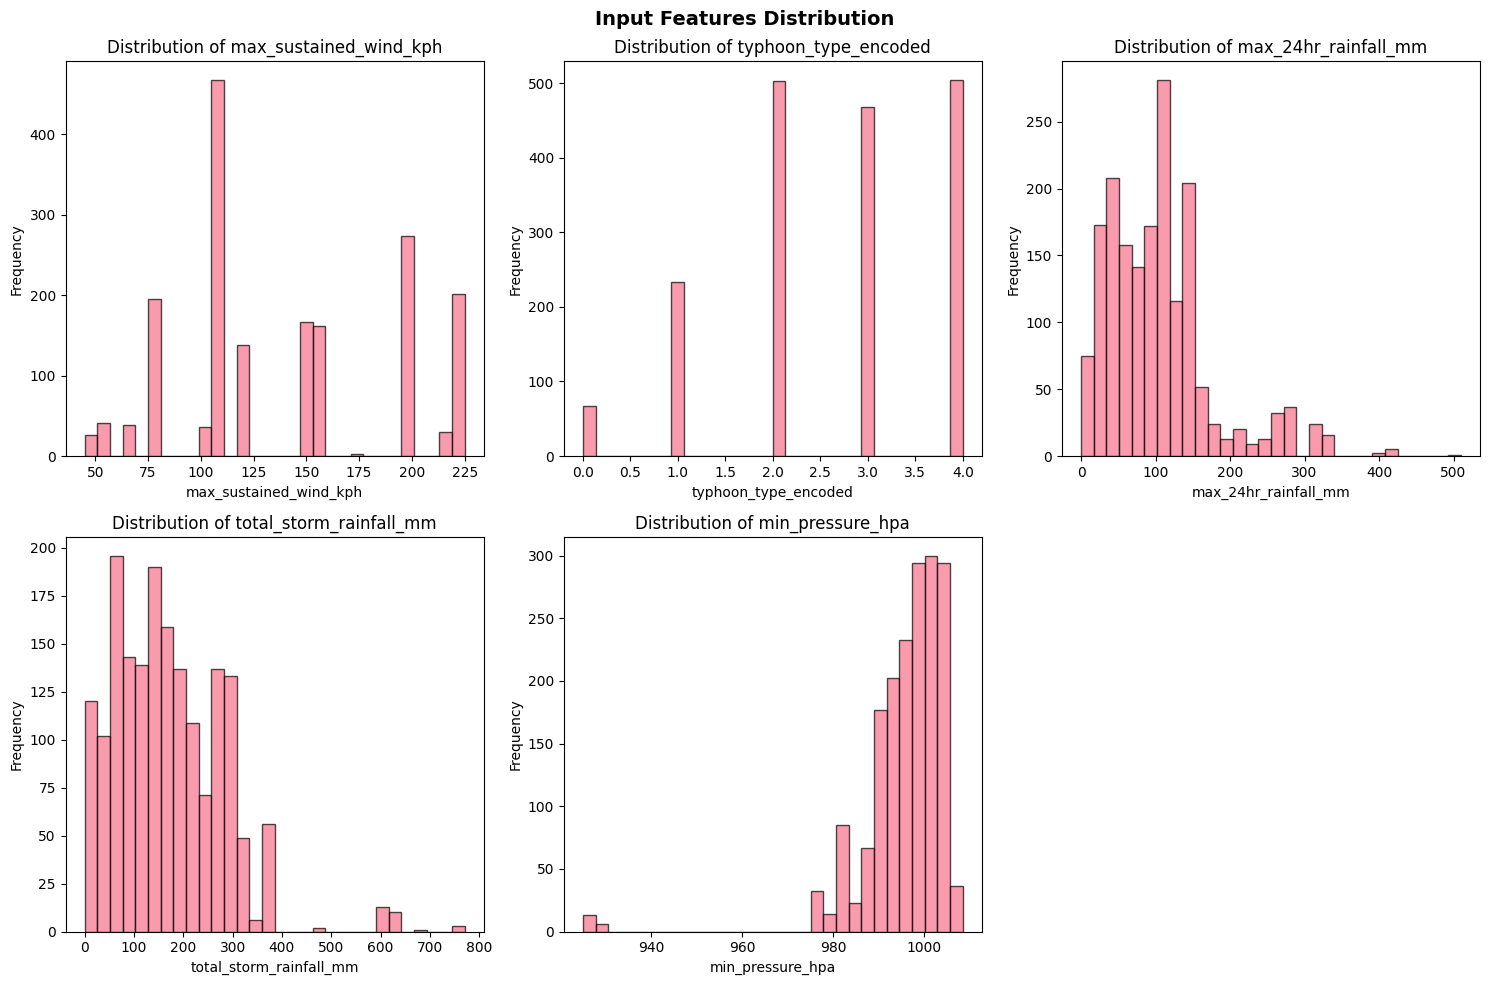

In [16]:
# Visualize input feature distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(INPUT_FEATURES_ENCODED):
    if i < len(axes):
        axes[i].hist(X[col], bins=30, edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

# Hide extra subplot
if len(INPUT_FEATURES_ENCODED) < len(axes):
    axes[-1].set_visible(False)

plt.suptitle('Input Features Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

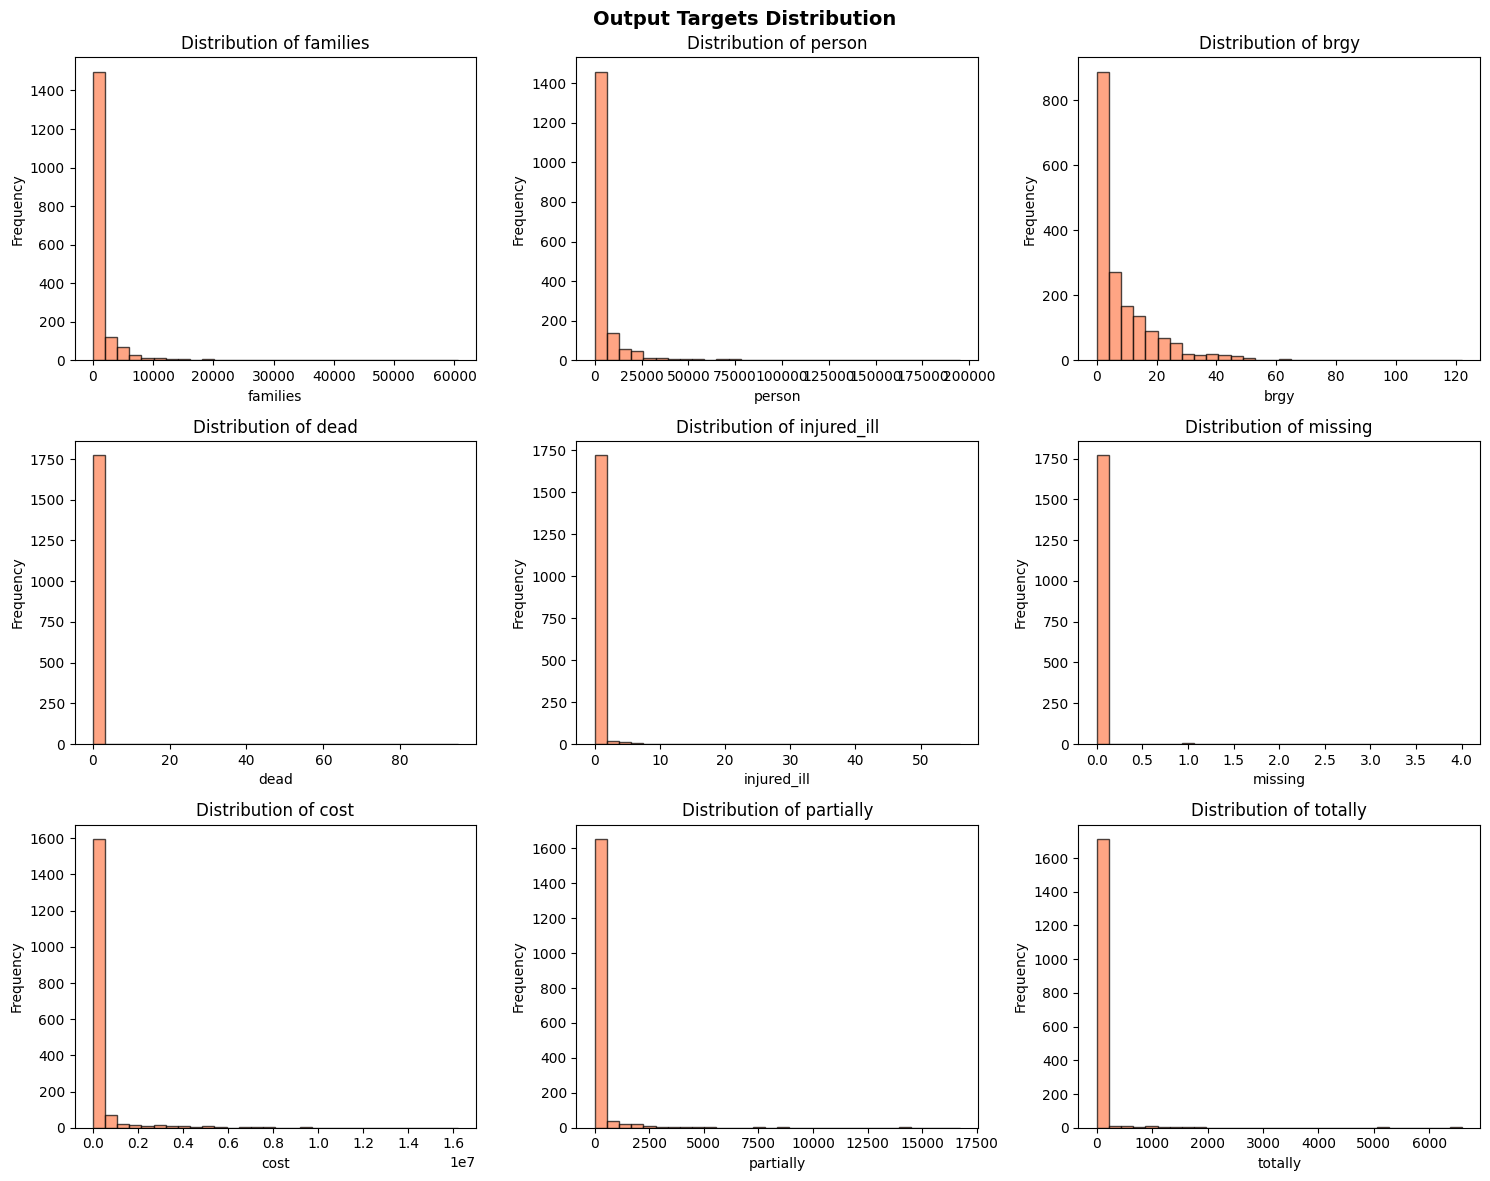

In [17]:
# Visualize output target distributions
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(OUTPUT_TARGETS):
    axes[i].hist(y[col], bins=30, edgecolor='black', alpha=0.7, color='coral')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.suptitle('Output Targets Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

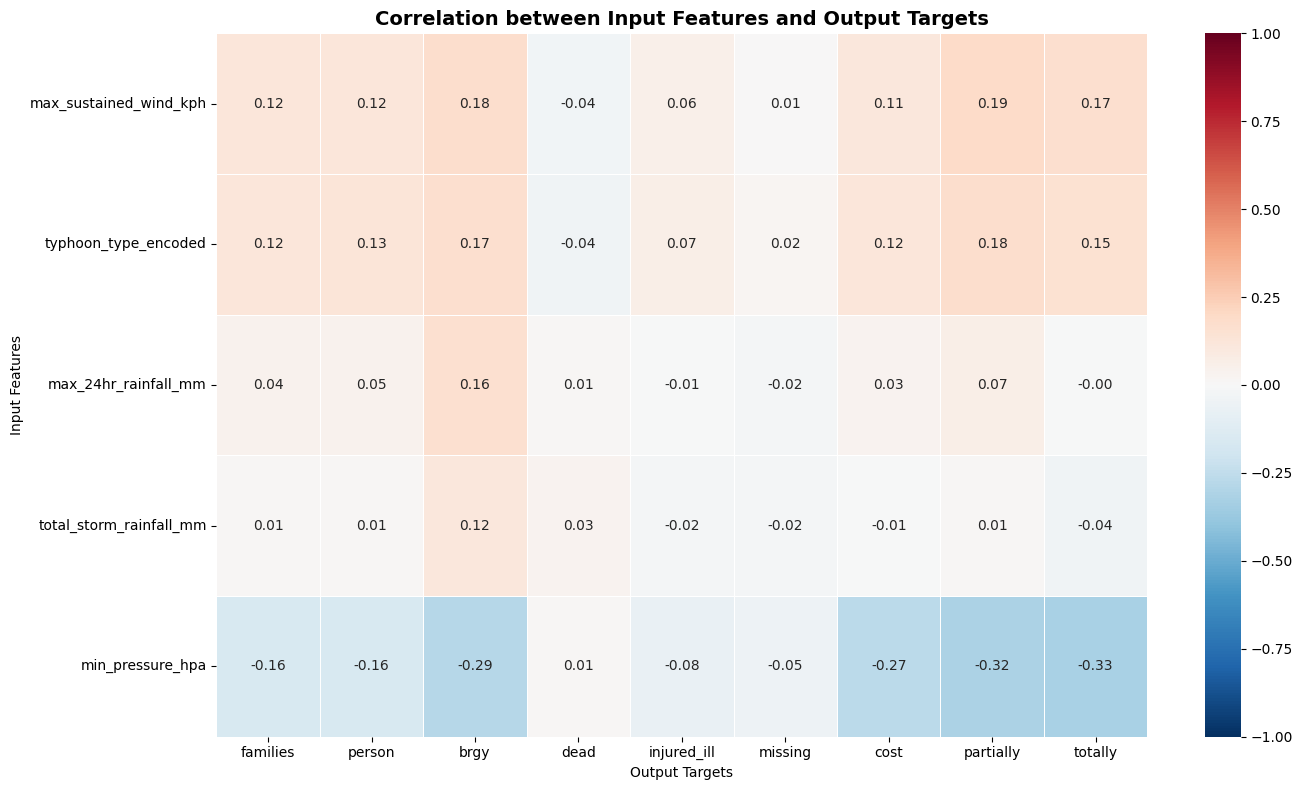

In [18]:
# Correlation heatmap between inputs and outputs
correlation_data = pd.concat([X, y], axis=1)
correlation_matrix = correlation_data.corr()

# Extract correlation between inputs and outputs
input_output_corr = correlation_matrix.loc[INPUT_FEATURES_ENCODED, OUTPUT_TARGETS]

plt.figure(figsize=(14, 8))
sns.heatmap(input_output_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation between Input Features and Output Targets', fontsize=14, fontweight='bold')
plt.xlabel('Output Targets')
plt.ylabel('Input Features')
plt.tight_layout()
plt.show()

## 5. Multi-Output Regression with Optuna Optimization

In [19]:
def evaluate_model(y_true, y_pred, target_names):
    """
    Evaluate multi-output regression model performance.
    
    Parameters:
    -----------
    y_true : array-like
        True target values
    y_pred : array-like
        Predicted target values
    target_names : list
        Names of target variables
    
    Returns:
    --------
    dict: Dictionary containing evaluation metrics for each target
    """
    results = {}
    
    for i, target in enumerate(target_names):
        y_t = y_true[:, i] if isinstance(y_true, np.ndarray) else y_true.iloc[:, i]
        y_p = y_pred[:, i]
        
        mse = mean_squared_error(y_t, y_p)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_t, y_p)
        r2 = r2_score(y_t, y_p)
        
        results[target] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        }
    
    # Calculate overall metrics
    overall_mse = mean_squared_error(y_true, y_pred)
    overall_r2 = r2_score(y_true, y_pred)
    
    results['overall'] = {
        'MSE': overall_mse,
        'RMSE': np.sqrt(overall_mse),
        'R2': overall_r2
    }
    
    return results


def print_evaluation_results(results, title="Model Evaluation Results"):
    """
    Print formatted evaluation results.
    """
    print("\n" + "="*80)
    print(title)
    print("="*80)
    
    print(f"\n{'Target':<20} {'MSE':>15} {'RMSE':>15} {'MAE':>15} {'R2':>10}")
    print("-"*75)
    
    for target, metrics in results.items():
        if target != 'overall':
            mae = metrics.get('MAE', 'N/A')
            mae_str = f"{mae:>15.2f}" if isinstance(mae, (int, float)) else f"{mae:>15}"
            print(f"{target:<20} {metrics['MSE']:>15.2f} {metrics['RMSE']:>15.2f} {mae_str} {metrics['R2']:>10.4f}")
    
    print("-"*75)
    overall = results['overall']
    print(f"{'OVERALL':<20} {overall['MSE']:>15.2f} {overall['RMSE']:>15.2f} {'':>15} {overall['R2']:>10.4f}")
    print("="*80)

In [20]:
# Define Optuna objective function for XGBoost Multi-Output Regressor
def optuna_xgb_objective(trial):
    """
    Optuna objective function for XGBoost hyperparameter optimization.
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Create Multi-Output XGBoost Regressor
    base_model = xgb.XGBRegressor(**params)
    model = MultiOutputRegressor(base_model)
    
    # Use cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    cv_scores = []
    for train_idx, val_idx in kfold.split(X_train_scaled):
        X_cv_train = X_train_scaled.iloc[train_idx]
        X_cv_val = X_train_scaled.iloc[val_idx]
        y_cv_train = y_train.iloc[train_idx]
        y_cv_val = y_train.iloc[val_idx]
        
        model.fit(X_cv_train, y_cv_train)
        y_pred = model.predict(X_cv_val)
        
        r2 = r2_score(y_cv_val, y_pred)
        cv_scores.append(r2)
    
    return np.mean(cv_scores)


print("Optuna objective function defined successfully!")

Optuna objective function defined successfully!


In [ ]:
# Run Optuna optimization for XGBoost
print("="*80)
print("OPTUNA HYPERPARAMETER OPTIMIZATION - XGBOOST")
print("="*80)

# Create Optuna study
optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = TPESampler(seed=42)
xgb_study = optuna.create_study(
    direction='maximize',
    study_name='xgb_multioutput_optimization',
    sampler=sampler
)

# Optimize
print("\nOptimizing XGBoost hyperparameters...")
xgb_study.optimize(optuna_xgb_objective, n_trials=50, show_progress_bar=True)

# Display best parameters
print("\n" + "="*60)
print("XGBOOST OPTIMIZATION RESULTS")
print("="*60)
print(f"Best R2 Score (CV): {xgb_study.best_value:.4f}")
print("\nBest Hyperparameters:")
for param, value in xgb_study.best_params.items():
    print(f"  {param}: {value}")

OPTUNA HYPERPARAMETER OPTIMIZATION - XGBOOST

Optimizing XGBoost hyperparameters...


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# Define Optuna objective function for Random Forest Multi-Output Regressor
def optuna_rf_objective(trial):
    """
    Optuna objective function for Random Forest hyperparameter optimization.
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Create Multi-Output Random Forest Regressor
    model = RandomForestRegressor(**params)
    
    # Use cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    cv_scores = []
    for train_idx, val_idx in kfold.split(X_train_scaled):
        X_cv_train = X_train_scaled.iloc[train_idx]
        X_cv_val = X_train_scaled.iloc[val_idx]
        y_cv_train = y_train.iloc[train_idx]
        y_cv_val = y_train.iloc[val_idx]
        
        model.fit(X_cv_train, y_cv_train)
        y_pred = model.predict(X_cv_val)
        
        r2 = r2_score(y_cv_val, y_pred)
        cv_scores.append(r2)
    
    return np.mean(cv_scores)


print("Random Forest objective function defined!")

In [ ]:
# Run Optuna optimization for Random Forest
print("="*80)
print("OPTUNA HYPERPARAMETER OPTIMIZATION - RANDOM FOREST")
print("="*80)

# Create Optuna study
rf_study = optuna.create_study(
    direction='maximize',
    study_name='rf_multioutput_optimization',
    sampler=sampler
)

# Optimize
print("\nOptimizing Random Forest hyperparameters...")
rf_study.optimize(optuna_rf_objective, n_trials=50, show_progress_bar=True)

# Display best parameters
print("\n" + "="*60)
print("RANDOM FOREST OPTIMIZATION RESULTS")
print("="*60)
print(f"Best R2 Score (CV): {rf_study.best_value:.4f}")
print("\nBest Hyperparameters:")
for param, value in rf_study.best_params.items():
    print(f"  {param}: {value}")

## 6. Train Final Models with Best Parameters

In [ ]:
# Train final XGBoost model with best parameters
print("="*80)
print("TRAINING FINAL XGBOOST MODEL")
print("="*80)

best_xgb_params = xgb_study.best_params.copy()
best_xgb_params['random_state'] = 42
best_xgb_params['n_jobs'] = -1

# Create and train the model
xgb_base = xgb.XGBRegressor(**best_xgb_params)
xgb_model = MultiOutputRegressor(xgb_base)
xgb_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate
xgb_results = evaluate_model(y_test.values, y_pred_xgb, OUTPUT_TARGETS)
print_evaluation_results(xgb_results, "XGBOOST MULTI-OUTPUT REGRESSION RESULTS")

In [ ]:
# Train final Random Forest model with best parameters
print("="*80)
print("TRAINING FINAL RANDOM FOREST MODEL")
print("="*80)

best_rf_params = rf_study.best_params.copy()
best_rf_params['random_state'] = 42
best_rf_params['n_jobs'] = -1

# Create and train the model
rf_model = RandomForestRegressor(**best_rf_params)
rf_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate
rf_results = evaluate_model(y_test.values, y_pred_rf, OUTPUT_TARGETS)
print_evaluation_results(rf_results, "RANDOM FOREST MULTI-OUTPUT REGRESSION RESULTS")

## 7. Model Comparison

In [ ]:
# Compare model performances
print("="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

comparison_data = []
for target in OUTPUT_TARGETS:
    comparison_data.append({
        'Target': target,
        'XGBoost_R2': xgb_results[target]['R2'],
        'XGBoost_RMSE': xgb_results[target]['RMSE'],
        'RF_R2': rf_results[target]['R2'],
        'RF_RMSE': rf_results[target]['RMSE'],
        'Best_Model': 'XGBoost' if xgb_results[target]['R2'] > rf_results[target]['R2'] else 'Random Forest'
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n")
display(comparison_df)

print(f"\nOverall Best Model: {'XGBoost' if xgb_results['overall']['R2'] > rf_results['overall']['R2'] else 'Random Forest'}")
print(f"  XGBoost Overall R2: {xgb_results['overall']['R2']:.4f}")
print(f"  Random Forest Overall R2: {rf_results['overall']['R2']:.4f}")

In [ ]:
# Visualize R2 comparison
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(OUTPUT_TARGETS))
width = 0.35

xgb_r2 = [xgb_results[t]['R2'] for t in OUTPUT_TARGETS]
rf_r2 = [rf_results[t]['R2'] for t in OUTPUT_TARGETS]

bars1 = ax.bar(x - width/2, xgb_r2, width, label='XGBoost', color='steelblue', edgecolor='white')
bars2 = ax.bar(x + width/2, rf_r2, width, label='Random Forest', color='coral', edgecolor='white')

ax.set_xlabel('Target Variable', fontsize=12)
ax.set_ylabel('R² Score', fontsize=12)
ax.set_title('Model Comparison: R² Score by Target Variable', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(OUTPUT_TARGETS, rotation=45, ha='right')
ax.legend()
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis

In [ ]:
# Get feature importance from Random Forest (it natively supports multi-output)
feature_importance = pd.DataFrame({
    'Feature': INPUT_FEATURES_ENCODED,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("="*60)
print("FEATURE IMPORTANCE (Random Forest)")
print("="*60)
print(feature_importance.to_string(index=False))

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_importance)))
bars = ax.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors)

ax.set_xlabel('Importance Score', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Feature Importance for Typhoon Impact Prediction', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for bar, importance in zip(bars, feature_importance['Importance']):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
            f'{importance:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Get feature importance per target from XGBoost
print("="*80)
print("FEATURE IMPORTANCE PER TARGET (XGBoost)")
print("="*80)

xgb_importance_per_target = {}
for i, target in enumerate(OUTPUT_TARGETS):
    estimator = xgb_model.estimators_[i]
    importance = estimator.feature_importances_
    xgb_importance_per_target[target] = importance

importance_df = pd.DataFrame(xgb_importance_per_target, index=INPUT_FEATURES_ENCODED)
print(importance_df.round(4))

# Heatmap of feature importance per target
plt.figure(figsize=(14, 6))
sns.heatmap(importance_df, annot=True, fmt='.3f', cmap='YlOrRd', linewidths=0.5)
plt.title('Feature Importance per Target Variable (XGBoost)', fontsize=14, fontweight='bold')
plt.xlabel('Target Variable')
plt.ylabel('Input Feature')
plt.tight_layout()
plt.show()

## 9. Prediction vs Actual Visualization

In [ ]:
# Select best model based on overall R2
best_model_name = 'XGBoost' if xgb_results['overall']['R2'] > rf_results['overall']['R2'] else 'Random Forest'
best_predictions = y_pred_xgb if best_model_name == 'XGBoost' else y_pred_rf
best_results = xgb_results if best_model_name == 'XGBoost' else rf_results

print(f"Using {best_model_name} for visualization (Best Overall R2: {best_results['overall']['R2']:.4f})")

In [ ]:
# Plot Predicted vs Actual for each target
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, target in enumerate(OUTPUT_TARGETS):
    ax = axes[i]
    actual = y_test.iloc[:, i].values
    predicted = best_predictions[:, i]
    
    ax.scatter(actual, predicted, alpha=0.5, s=20)
    
    # Add perfect prediction line
    min_val = min(actual.min(), predicted.min())
    max_val = max(actual.max(), predicted.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual', fontsize=10)
    ax.set_ylabel('Predicted', fontsize=10)
    ax.set_title(f'{target}\nR² = {best_results[target]["R2"]:.4f}', fontsize=11)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Predicted vs Actual Values ({best_model_name})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 10. Residual Analysis

In [ ]:
# Residual plots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, target in enumerate(OUTPUT_TARGETS):
    ax = axes[i]
    actual = y_test.iloc[:, i].values
    predicted = best_predictions[:, i]
    residuals = actual - predicted
    
    ax.scatter(predicted, residuals, alpha=0.5, s=20)
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
    
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('Residuals', fontsize=10)
    ax.set_title(f'{target}', fontsize=11)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Residual Plots ({best_model_name})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 11. Save Models and Results

In [ ]:
# Create timestamp for file naming
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save models
joblib.dump(xgb_model, f'../models/xgb_multioutput_model_{timestamp}.joblib')
joblib.dump(rf_model, f'../models/rf_multioutput_model_{timestamp}.joblib')
joblib.dump(scaler_X, f'../models/feature_scaler_{timestamp}.joblib')

print(f"Models saved with timestamp: {timestamp}")
print(f"  - XGBoost model: xgb_multioutput_model_{timestamp}.joblib")
print(f"  - Random Forest model: rf_multioutput_model_{timestamp}.joblib")
print(f"  - Feature scaler: feature_scaler_{timestamp}.joblib")

In [ ]:
# Save results to CSV
results_summary = []
for target in OUTPUT_TARGETS:
    results_summary.append({
        'Target': target,
        'XGBoost_R2': xgb_results[target]['R2'],
        'XGBoost_RMSE': xgb_results[target]['RMSE'],
        'XGBoost_MAE': xgb_results[target]['MAE'],
        'RF_R2': rf_results[target]['R2'],
        'RF_RMSE': rf_results[target]['RMSE'],
        'RF_MAE': rf_results[target]['MAE']
    })

results_df = pd.DataFrame(results_summary)
results_df.to_csv(f'../models/mor_results_{timestamp}.csv', index=False)
print(f"Results saved to: mor_results_{timestamp}.csv")
display(results_df)

In [ ]:
# Save best hyperparameters
hyperparams = {
    'xgboost': xgb_study.best_params,
    'random_forest': rf_study.best_params
}

joblib.dump(hyperparams, f'../models/best_hyperparameters_{timestamp}.joblib')
print(f"Best hyperparameters saved to: best_hyperparameters_{timestamp}.joblib")

## 12. Sample Predictions

In [ ]:
# Make sample predictions
print("="*80)
print("SAMPLE PREDICTIONS")
print("="*80)

# Select a few test samples
sample_indices = np.random.choice(len(X_test), size=5, replace=False)

for idx in sample_indices:
    print(f"\n--- Sample {idx} ---")
    print("Input Features:")
    for i, col in enumerate(INPUT_FEATURES_ENCODED):
        print(f"  {col}: {X_test.iloc[idx, i]:.2f}")
    
    print("\nActual vs Predicted:")
    print(f"{'Target':<15} {'Actual':>12} {'Predicted':>12} {'Error':>12}")
    print("-"*55)
    for i, target in enumerate(OUTPUT_TARGETS):
        actual = y_test.iloc[idx, i]
        predicted = best_predictions[sample_indices.tolist().index(idx), i]
        error = actual - predicted
        print(f"{target:<15} {actual:>12.2f} {predicted:>12.2f} {error:>12.2f}")

## 13. Final Summary

In [ ]:
# Print final summary
print("="*80)
print("MULTI-OUTPUT REGRESSION - FINAL SUMMARY")
print("="*80)

print("\n1. DATASET INFORMATION")
print(f"   - Total samples: {len(df)}")
print(f"   - Training samples: {len(X_train)}")
print(f"   - Testing samples: {len(X_test)}")
print(f"   - Input features: {len(INPUT_FEATURES_ENCODED)}")
print(f"   - Output targets: {len(OUTPUT_TARGETS)}")

print("\n2. INPUT FEATURES")
for feat in INPUT_FEATURES_ENCODED:
    print(f"   - {feat}")

print("\n3. OUTPUT TARGETS")
for target in OUTPUT_TARGETS:
    print(f"   - {target}")

print("\n4. MODEL PERFORMANCE (Test Set)")
print(f"   XGBoost:")
print(f"     - Overall R²: {xgb_results['overall']['R2']:.4f}")
print(f"     - Overall RMSE: {xgb_results['overall']['RMSE']:.2f}")
print(f"   Random Forest:")
print(f"     - Overall R²: {rf_results['overall']['R2']:.4f}")
print(f"     - Overall RMSE: {rf_results['overall']['RMSE']:.2f}")

print(f"\n5. BEST MODEL: {best_model_name}")
print(f"   - Overall R²: {best_results['overall']['R2']:.4f}")

print("\n6. TOP CONTRIBUTING FEATURES (Random Forest)")
for _, row in feature_importance.head(3).iterrows():
    print(f"   - {row['Feature']}: {row['Importance']:.4f}")

print("\n" + "="*80)
print("END OF MULTI-OUTPUT REGRESSION ANALYSIS")
print("="*80)

MAACLI report exported to: ../cluster_explanations_MAACLI_KMeans.txt
